In [4]:
import keras
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model, to_categorical
from keras import backend as K
import tensorflow as tf

from process_data import load_train_data, process_daq
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sVAE_utils import sampling, plot_results

import numpy as np
import matplotlib.pyplot as plt
import os
from gpu import set_gpu

set_gpu()
tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.
Num GPUs Available:  1


In [8]:
x = np.array([1,2, 3, 4, 5, 6])

In [9]:
y = x.reshape(2,3)

In [2]:
# Load raw EMG data
feat,params,daq = load_train_data('train_data_raw_AB.mat')
raw = process_daq(daq,params)
raw = raw[::2,:,:].transpose(2,1,0)

# Index EMG data
sub = 14
grp = 1
ind = (params[:,0] == sub) & (params[:,3] == grp)

# Shuffle and split data
feat_s, label_s = shuffle(raw[ind,:,:],params[ind,-2,np.newaxis])
x_train, x_test, y_train, y_test = train_test_split(feat_s, label_s, test_size=0.3, random_state=0, stratify=label_s)

# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]
y_train = np.squeeze(y_train-1)
y_test = np.squeeze(y_test-1)

In [3]:
original_dim = x_train.shape[0] * x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 64
latent_dim = 2
epochs = 100

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(6,100,1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(3*50*32, activation="relu")(latent_inputs)
x = Reshape((3, 50, 32))(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# New: add a classifier
clf_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_clf')
clf_outputs = Dense(7, activation='softmax', name='class_output')(clf_latent_inputs)
clf_supervised = Model(clf_latent_inputs, clf_outputs, name='clf')
clf_supervised.summary()

# instantiate VAE model
outputs = [decoder(encoder(inputs)[2]), clf_supervised(encoder(inputs)[2])]
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6, 100, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 50, 32)    320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 50, 32)    9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4800)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [4]:
models = (encoder, decoder)
data = (x_test, y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

reconstruction_loss = tf.reduce_mean(mse(inputs, outputs[0]))

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean((reconstruction_loss + kl_loss)/100.0)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', loss={'clf': 'categorical_crossentropy'})

In [16]:
vae.fit(x_train, {'clf': y_train},
        epochs=epochs,
        batch_size=batch_size,
        validation_split=.1)
vae.save_weights('vae_mlp_mnist.h5')

Train on 2205 samples, validate on 245 samples
Epoch 1/100
2205/2205 [==============================] - 1s 530us/step - loss: 4.3004 - clf_loss: 0.3512 - val_loss: 3.7179 - val_clf_loss: 0.2352
Epoch 2/100
2205/2205 [==============================] - 0s 159us/step - loss: 3.4797 - clf_loss: 0.2087 - val_loss: 3.4790 - val_clf_loss: 0.2032
Epoch 3/100
2205/2205 [==============================] - 0s 160us/step - loss: 3.3666 - clf_loss: 0.1939 - val_loss: 3.4503 - val_clf_loss: 0.2004
Epoch 4/100
2205/2205 [==============================] - 0s 159us/step - loss: 3.3248 - clf_loss: 0.1719 - val_loss: 3.4482 - val_clf_loss: 0.2045
Epoch 5/100
2205/2205 [==============================] - 0s 159us/step - loss: 3.3028 - clf_loss: 0.1548 - val_loss: 3.4263 - val_clf_loss: 0.1843
Epoch 6/100
2205/2205 [==============================] - 0s 162us/step - loss: 3.2823 - clf_loss: 0.1399 - val_loss: 3.4219 - val_clf_loss: 0.1884
Epoch 7/100
2205/2205 [==============================] - 0s 159us/step 

In [5]:
vae.load_weights('vae_mlp_mnist.h5')

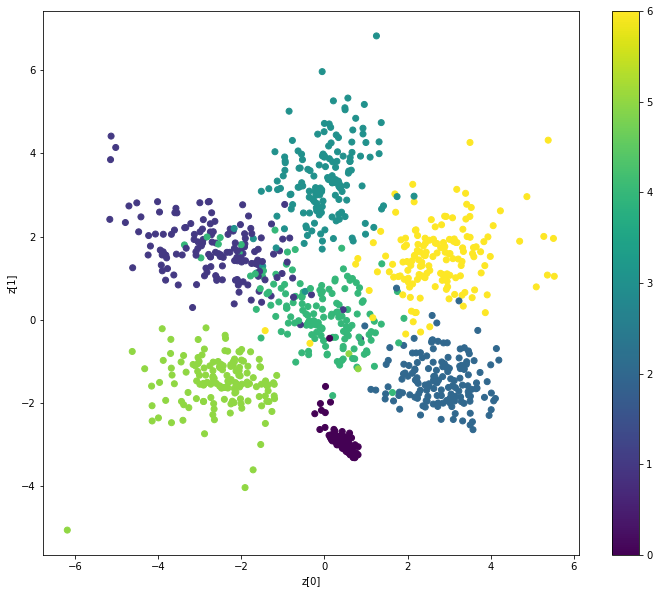

In [17]:
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")

In [18]:
y_pred = np.argmax(vae.predict(x=x_test)[1], axis=1)
np.sum(np.argmax(y_test, axis=1) == y_pred)/y_pred.shape[0]

AxisError: axis 1 is out of bounds for array of dimension 1

In [43]:
# Index EMG data
test_grp = 6
test_ind = (params[:,0] == sub) & (params[:,3] == test_grp)

In [ ]:
# Shuffle and split data
test_feat, test_label = shuffle(raw[test_ind,:,:],params[test_ind,-2,np.newaxis])
x_test = scaler.transform(test_feat.reshape(test_feat.shape[0],-1)).reshape(test_feat.shape)
x_test = x_test[...,np.newaxis]
y_test = np.squeeze(test_label-1)

y_pred = np.argmax(vae.predict(x=x_test)[1], axis=1)
np.sum(y_test == y_pred)/y_pred.shape[0]

In [44]:
from lda import train_lda, predict

# Shuffle and split data
x_feats, y_feats = shuffle(feat[ind,:],params[ind,-2,np.newaxis])
x_test, y_test = shuffle(feat[test_ind,:],params[test_ind,-2,np.newaxis])

x_train, _, y_train, _ = train_test_split(x_feats, y_feats, test_size=0.3, random_state=0, stratify=label_s)

w,c = train_lda(x_train,y_train)
out = predict(x_test,w,c)
np.sum(out.reshape(y_test.shape) == y_test-1)/y_test.shape[0]

0.5365714285714286